In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
train_data = pd.read_csv("./KDDTrain+.txt")
test_data = pd.read_csv("./KDDTest+.txt")


In [5]:
columns = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
           'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted',
           'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login',
           'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
           'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
           'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
           'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
           'dst_host_srv_rerror_rate', 'attack', 'level']

train_data.columns = columns
test_data.columns = columns


In [6]:
full_data = pd.concat([train_data, test_data], ignore_index=True)

In [7]:
label_encoders = {}
for column in ['protocol_type', 'service', 'flag']:
    le = LabelEncoder()
    full_data[column] = le.fit_transform(full_data[column])
    label_encoders[column] = le

In [8]:
full_data['attack'] = full_data['attack'].apply(lambda x: 1 if x != 'normal' else 0)

In [9]:
X = full_data.drop(['attack', 'level'], axis=1)
y = full_data['attack']

In [10]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rfe = RFE(rf, n_features_to_select=30)
rfe.fit(X, y)
X_selected = X[X.columns[rfe.support_]]

In [11]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

In [12]:
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42, stratify=y)

# Convert labels to categorical (optional for multi-class, keep as is for binary classification)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


In [16]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    LSTM(50),
    Dropout(0.3),
    Dense(2, activation='softmax')  # Change from 1 neuron (sigmoid) to 2 neurons (softmax)
])

# Compile the model with categorical loss
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [17]:


# Train Model
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test))

# Evaluate Model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {accuracy:.4f}")

Epoch 1/20


1857/1857 [==============================] - 11s 4ms/step - loss: 0.1066 - accuracy: 0.9593 - val_loss: 0.0628 - val_accuracy: 0.9764
Epoch 2/20
1857/1857 [==============================] - 6s 3ms/step - loss: 0.0639 - accuracy: 0.9752 - val_loss: 0.0541 - val_accuracy: 0.9797
Epoch 3/20
1857/1857 [==============================] - 7s 4ms/step - loss: 0.0561 - accuracy: 0.9786 - val_loss: 0.0479 - val_accuracy: 0.9821
Epoch 4/20
1857/1857 [==============================] - 6s 3ms/step - loss: 0.0511 - accuracy: 0.9807 - val_loss: 0.0437 - val_accuracy: 0.9843
Epoch 5/20
1857/1857 [==============================] - 6s 3ms/step - loss: 0.0477 - accuracy: 0.9821 - val_loss: 0.0420 - val_accuracy: 0.9844
Epoch 6/20
1857/1857 [==============================] - 7s 4ms/step - loss: 0.0455 - accuracy: 0.9830 - val_loss: 0.0404 - val_accuracy: 0.9850
Epoch 7/20
1857/1857 [==============================] - 6s 3ms/step - loss: 0.0433 - accuracy: 0.9837 - val_loss: 0.0382 - val_accura

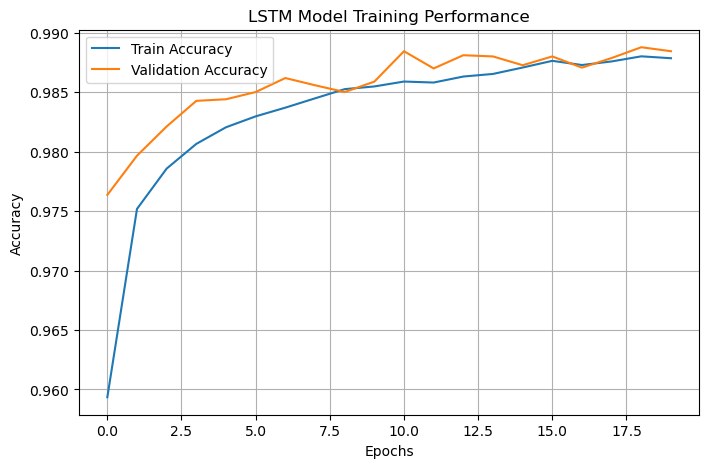

In [18]:
# Plot Training Loss & Accuracy
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.title("LSTM Model Training Performance")
plt.show()

In [ ]:
# Predict on Test Data
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Convert y_test back to labels
y_test_labels = np.argmax(y_test, axis=1)

929/929 [==============================] - 2s 1ms/step


In [26]:
# Convert one-hot encoded labels to single-class labels
y_test_labels = np.argmax(y_test, axis=1)  # Convert test labels to class index
y_pred_labels = np.argmax(y_pred, axis=1)  # Convert predictions to class index

# Now use classification metrics
print("Confusion Matrix:\n", confusion_matrix(y_test_labels, y_pred_labels))
print("Classification Report:\n", classification_report(y_test_labels, y_pred_labels))


Confusion Matrix:
 [[15225   186]
 [  157 14135]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     15411
           1       0.99      0.99      0.99     14292

    accuracy                           0.99     29703
   macro avg       0.99      0.99      0.99     29703
weighted avg       0.99      0.99      0.99     29703

